This notebook contiues the preious benchmarks of pair contacts. The primary aim is to quantify the implementation of periodic boundary conditions with the non-periodic octree. Previous benchmarks (see [here](https://github.com/ayushsuhane/Benchmarks_Distance/blob/master/Notebooks/BM_PairContact_MOD.ipynb) concluded that cell-lists are probably better in comparison to KDtree and brute force, specifically at higher number of particles, whereas brute force is most effective till 1k particles.  

Octree based method was limited as PBC handling was not implemented. Recently, single point query were done by augmenting the coordinates in a relatively large box to incorporate periodicity in the box. It was found that such augmenting strategy leads to a large time for distance calculations specifically for large number of particles i.e beyond 4k-5k particles. However, total time for single query were limited by building time and therefore not very much reliable. Query time for Octree was very low as compared to periodic KDTree, but was similar to other non-periodic KDTree implementations.

In this notebook, we first benchmark Octree, Cython FATSLiM, CellGrid and periodic KDTree for the use case of evaluating all the contacts within a certain fixed distance. This will then be followed by an actual case scenario of evaluating the bonds between the particles.

In [1]:
import numpy as np
import pcl
from core_ns import FastNS
from MDAnalysis.lib.pkdtree import PeriodicKDTree
import cellgrid

In [2]:
%matplotlib inline

Lets begin by defining the helper function to augment the coordinates, which can be used by octree

In [3]:
from collections import defaultdict
def augment(points, cutoff, box):
    """
    Augments the cordinates and returns the coordinates in 
    the extended box, such that all the atoms in the box 
    are PBC aware
    
    Parameters
    ----------
    points : coordinates of dimension (N, 3)
    cutoff : cutoff radius 
    box : PBC aware box
    
    Returns
    -------
    augmented_coords : similar to points but added coordinates 
    mapid : hash map with the original to artificial mapping
    """
    a, b, c = box[:3]
    dm = np.array([[a, 0, 0], [0, b, 0], [0, 0, c]], dtype=np.float32)
    rm = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]], dtype=np.float32)
    
    augmented_coords = points.copy() ## So as to not change the original coordinates
    mapid = defaultdict(list) # hash maps
    for idx, coords in enumerate(points):
        images = list()
        distances = np.dot(rm, coords)
        displacements = list(dm[np.where(distances < cutoff)[0]])
        distances = np.einsum('ij,ij->i', rm,dm - coords)
        displacements.extend(list(-dm[np.where(distances < cutoff)[0]]))
        n_displacements = len(displacements)
        if n_displacements > 1:
            for start in range(n_displacements - 1, -1, -1):
                for i in range(start+1, len(displacements)):
                    displacements.append(displacements[start]+displacements[i])
        images.extend([coords + d for d in displacements])
        updated_N = len(augmented_coords)
        if len(images) > 0 :
            augmented_coords = np.append(augmented_coords, [images[i] for i in range(len(images))], axis = 0)
            for newidx in range(len(images)):
                mapid[updated_N + newidx].append(idx)
    return augmented_coords, mapid

In [4]:
def inverse_augment(pairs, mapid, N):
    """
    Returns the set of unique pairs
    
    pairs is a list of pairs which needs to be replaced
    
    Parameters
    ----------
    pairs : array
    mapid : hash map returned from augment 
    N : Number of points in original indices
    
    Returns
    -------
    numpy array of unique bonds
    """
    art_bonds = pairs.copy()
    for idx, [a,b] in enumerate(art_bonds):
        if a >= N:
            art_bonds[idx][0] = mapid[a][0]
        if b >= N:
            art_bonds[idx][1] = mapid[b][0]
    bonds = np.unique(np.sort(art_bonds, axis = 1), axis = 0)
    return bonds

# Method Definitions

In [5]:
def octree_select(coords, maxdist):
    cloud = pcl.PointCloud(coords)
    resolution = 0.2*box[0]
    octree = cloud.make_octreeSearch(resolution)
    octree.add_points_from_input_cloud()
    bonds = []
    for index, coord in enumerate(coords):
        [ind, sqdist] = octree.radius_search (coord, maxdist)
        for j in ind:
            if index > j:
                bonds.append((index, j))
    return np.array(bonds)

In [6]:
def octree(points, maxdist, box):
    augment_coords, mapid = augment(points, maxdist, box)
    art_bonds = octree_select(augment_coords, maxdist)
    bonds = inverse_augment(art_bonds, mapid, len(points))
    return bonds

In [7]:
def ns(points, maxdist, box):
    triclinic_box = np.array([[box[0], 0, 0],[0, box[1], 0],[0,0,box[2]]], dtype=np.float32)
    searcher = FastNS(triclinic_box)
    searcher.set_cutoff(maxdist)
    searcher.set_coords(points)
    searcher.prepare()
    results, sqdist, indx = searcher.search(points)
    bonds = []
    for i,arr in enumerate(indx):
        for j in range(len(arr)):
            if(i>arr[j]):
                bonds.append((i,arr[j]))
    return np.array(bonds)

In [8]:
import MDAnalysis.lib.distances as distances
def pkdtree(points, maxdist, box):
    epsilon = 1e-5 #to avoid the same point
    kdtree = PeriodicKDTree(box,bucket_size=10)
    kdtree.set_coords(points)
    pair, d = [], []
    for idx,centers in enumerate(points):
        kdtree.search(centers,maxdist)
        indices = kdtree.get_indices()
        indices = [i for i in indices if i > idx]
        dist = distances.distance_array(centers.reshape((1,3)), points[indices],box=box)[0]
        mask = np.where((dist > epsilon) & (dist <= maxdist))[0]
        for j in mask:
            pair.append((idx,indices[j]))
            d.append(dist[j])
    return np.asarray(pair)

In [9]:
def cg(points, maxdist, box):
    indx,dist = cellgrid.capped_self_distance_array(points,maxdist,box=box[:3])
    mask = np.where(dist<maxdist)
    return indx[mask]

In [10]:
import MDAnalysis.lib.distances as distances
def bf(points, maxdist, box):
    bonds, distance = [], []
    for i,coordinate in enumerate(points):
        dist = distances.distance_array(points[i][None, :], points[i + 1:],box=box)[0]
        idx = np.where((dist <= maxdist))[0]
        for a in idx:
            j = i + 1 + a
            atom_j = points[j]
            bonds.append((i, j))
            #distance.append((dist[a]))
    return np.asarray(bonds)

# helper function

In [11]:
def get_coords(box,Npoints):
    return (np.random.uniform(low=0,high=1.0,size=(Npoints,3))*box[:3]).astype(np.float32)

# Test for a simple case

In [20]:
box = np.array([100,100,100,90,90,90],dtype=np.float32)
maxdist = 10.0
points = get_coords(box, 100000)

In [14]:
bonds_ns = ns(points, maxdist, box)

In [15]:
bonds_cg = cg(points, maxdist, box)

In [ ]:
bonds_pkd = pkdtree(points, maxdist, box)

In [ ]:
bonds_oct = octree(points, maxdist, box)

In [16]:
%timeit ns(points, maxdist, box)

1min 15s ± 4.07 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%timeit cg(points, maxdist, box)

8.24 s ± 704 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%timeit pkdtree(points, maxdist, box)

2min 15s ± 3.73 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%timeit octree(points, maxdist, box)

5min 5s ± 5.32 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Lets check the other extreme of cutoff distance. 

In [13]:
box = np.array([100,100,100,90,90,90],dtype=np.float32)
maxdist = 1.0
points = get_coords(box, 100000)

In [14]:
%timeit ns(points, maxdist, box)

2.38 s ± 754 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%timeit cg(points, maxdist, box)

3.4 s ± 212 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%timeit pkdtree(points, maxdist, box)

14 s ± 365 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%timeit octree(points, maxdist, box)

8.05 s ± 249 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


For a particle size of 100k, time for cell-lists are definitely the lowest. However, the memory consumption is a little bit higher but not significantly high to freeze the system.

In [27]:
bonds_bf = bf(points, maxdist, box)

In [17]:
augment_coords, mapid = augment(points, maxdist, box)

In [18]:
art_bonds = octree_select(augment_coords, maxdist)

In [19]:
bonds = inverse_augment(art_bonds, mapid, len(points))

In [20]:
bonds.shape

(209337, 2)

# benchmarks

In [12]:
box = np.array([100,100,100,90,90,90],dtype=np.float32)
maxdist = 10.0
Npoints = np.logspace(2, 5, num = 10, dtype = np.int)

In [15]:
from tqdm import tqdm_notebook

res_total = defaultdict(list)

for N in tqdm_notebook(np.unique(Npoints)):
    points = get_coords(box, N)
    
    
    res = %timeit -q -o ns(points, maxdist, box)
    res_total['ns'].append(res.average)
    print('FATSLiM : N {} Time {}'.format(N, res.average))
    
    res = %timeit -q -o cg(points, maxdist, box)
    res_total['cg'].append(res.average)
    print('Cellgrid : N {} Time {}'.format(N, res.average))
   
    if N < Npoints[-1]:
        res = %timeit -q -o octree(points, maxdist, box)
        res_total['octree'].append(res.average)
        print('Octree : N {} Time {}'.format(N, res.average))
    
        res = %timeit -q -o bf(points, maxdist, box)
        res_total['bf'].append(res.average)
        print('Brute Force : N {} Time {}'.format(N, res.average))
    
        #res = %timeit -q -o pkdtree(points, maxdist, box)
        #res_total['pkd'].append(res.average)
        #print('PKDTree : N {} Time {}'.format(N, res.average))
    
    res_total['N'].append(N)

FATSLiM : N 100 Time 0.005590530142857168
Cellgrid : N 100 Time 0.0085182857142172
Octree : N 100 Time 0.013735571428501967
Brute Force : N 100 Time 0.0020471914285716203
FATSLiM : N 215 Time 0.00591906999999927
Cellgrid : N 215 Time 0.011159285714256839
Octree : N 215 Time 0.044533604285713534
Brute Force : N 215 Time 0.005313144285713796
FATSLiM : N 464 Time 0.0075616485714281876
Cellgrid : N 464 Time 0.00994771428567479
Octree : N 464 Time 0.030168699999996662
Brute Force : N 464 Time 0.01342458428571425
FATSLiM : N 1000 Time 0.016664628571425054
Cellgrid : N 1000 Time 0.014927237142857003
Octree : N 1000 Time 0.07704452857143289
Brute Force : N 1000 Time 0.04007434285713966
FATSLiM : N 2154 Time 0.05065368571428215
Cellgrid : N 2154 Time 0.029489114285716565
Octree : N 2154 Time 0.2634031428571169
Brute Force : N 2154 Time 0.13824957142857588
FATSLiM : N 4641 Time 0.17180358571427926
Cellgrid : N 4641 Time 0.11333611428571137
Octree : N 4641 Time 0.8320018571428136
Brute Force : N 

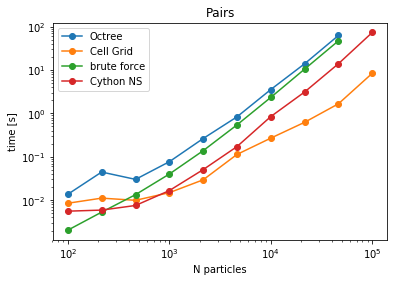

In [17]:
import matplotlib
import matplotlib.pyplot as plt

fig, axes = plt.subplots()

#axes.plot(res_total['N'][:-1], res_total['pkd'], 'o-', label='PeriodicKDT')
axes.plot(res_total['N'][:-1], res_total['octree'], 'o-', label='Octree')
axes.plot(res_total['N'], res_total['cg'], 'o-', label='Cell Grid')
axes.plot(res_total['N'][:-1], res_total['bf'], 'o-', label='brute force')
axes.plot(res_total['N'], res_total['ns'], 'o-', label='Cython NS')
axes.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Pairs')
axes.legend()

As it was pointed out that the cutoff radius is also one of the parameters, lets check the timings for selection of pair contacts for different pair contacts for 100k particles. As it can be seen that cellgrid and FATSLiM are the fastest for small and large cutoff radius as well as with number of particles. So, lets see the timings for different cutoff radius.

In [12]:
box = np.array([100,100,100,90,90,90],dtype=np.float32)
maxdist = np.linspace(1.0, 10.0, num = 10, dtype = np.float32)
Npoints = 50000
points = get_coords(box, Npoints)

In [14]:
from tqdm import tqdm_notebook

res_cutoff = defaultdict(list)

for max_d in tqdm_notebook(np.unique(maxdist)):
    
    res = %timeit -q -o ns(points, max_d, box)
    res_cutoff['ns'].append(res.average)
    
    res = %timeit -q -o cg(points, max_d, box)
    res_cutoff['cg'].append(res.average)
    
    
    res_cutoff['N'].append(max_d)

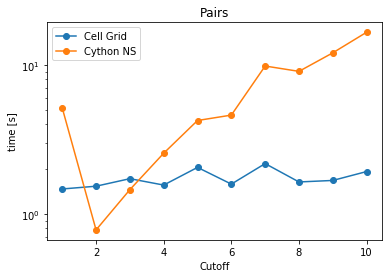

In [15]:
import matplotlib
import matplotlib.pyplot as plt

fig, axes = plt.subplots()


axes.plot(res_cutoff['N'], res_cutoff['cg'], 'o-', label='Cell Grid')
axes.plot(res_cutoff['N'], res_cutoff['ns'], 'o-', label='Cython NS')
axes.set(xlabel='Cutoff', ylabel='time [s]', yscale='log', title='Pairs')
axes.legend()